In [6]:
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
import os
import cPickle as pickle
import matplotlib
plt.style.use('seaborn-talk')
matplotlib.rcParams.update({'font.size': 15})

In [3]:
path = os.getcwd() + "/BloodCells/"

In [4]:
def load_image(impath):
    image = cv2.imread(impath)
    return image

In [14]:
# impath1 = path + "/images/TRAIN/NEUTROPHIL/_0_9649.jpeg"
impath2 = path + "/images/TRAIN/NEUTROPHIL/_0_9649.jpeg"
impath3 = path + "/images/TRAIN/NEUTROPHIL/_0_1095.jpeg"
impath1 = path + "/images/TRAIN/NEUTROPHIL/_7_5840.jpeg"
impath4 = path + "/images/TRAIN/NEUTROPHIL/_42_7923.jpeg"
# impath2 = path + "/images/TRAIN/NEUTROPHIL/_12_8847.jpeg"
# impath1 = path + "/images/TRAIN/LYMPHOCYTE/_0_204.jpeg"

In [22]:
impath5 = path + "/images/TRAIN/LYMPHOCYTE/_0_204.jpeg"
impath6 = path + "/images/TRAIN/LYMPHOCYTE/_0_278.jpeg"
impath7 = path + "/images/TRAIN/LYMPHOCYTE/_0_331.jpeg"
impath8 = path + "/images/TRAIN/LYMPHOCYTE/_0_547.jpeg"

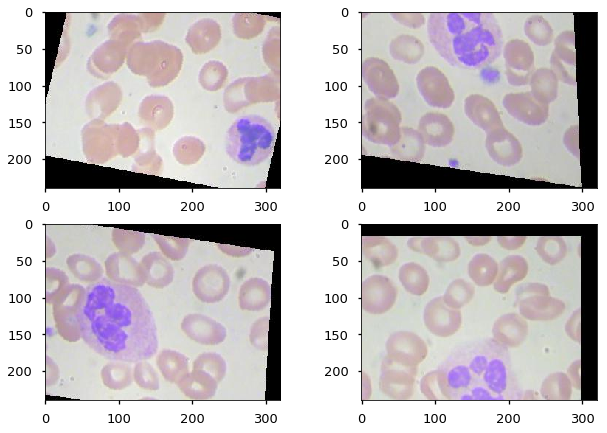

In [28]:
# Load examples images and plot them
imtest = load_image(impath1)
imtest2 = load_image(impath2)
imtest3 = load_image(impath3)
imtest4 = load_image(impath4)
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(cv2.cvtColor(imtest, cv2.COLOR_BGR2RGB))
axes[1, 0].imshow(cv2.cvtColor(imtest2, cv2.COLOR_BGR2RGB))
axes[0, 1].imshow(cv2.cvtColor(imtest3, cv2.COLOR_BGR2RGB))
axes[1, 1].imshow(cv2.cvtColor(imtest4, cv2.COLOR_BGR2RGB))
# plt.suptitle("Neutrophils images from the dataset")
plt.savefig(os.getcwd() + "/Latex/Graphs/Neutrophils_originals.pdf")
plt.show()

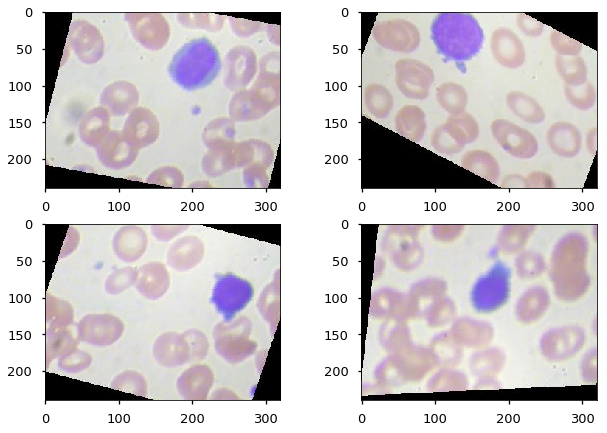

In [29]:
# Load examples images and plot them
imtest5 = load_image(impath5)
imtest6 = load_image(impath6)
imtest7 = load_image(impath7)
imtest8 = load_image(impath8)
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(cv2.cvtColor(imtest5, cv2.COLOR_BGR2RGB))
axes[1, 0].imshow(cv2.cvtColor(imtest6, cv2.COLOR_BGR2RGB))
axes[0, 1].imshow(cv2.cvtColor(imtest7, cv2.COLOR_BGR2RGB))
axes[1, 1].imshow(cv2.cvtColor(imtest8, cv2.COLOR_BGR2RGB))
# plt.suptitle("Lymphocytes images from the dataset")
plt.savefig(os.getcwd() + "/Latex/Graphs/Lymphocytes_originals.pdf")
plt.show()

In [31]:
# Pre processing first phase : efficient to blur the images 
# so as to find the darker zones in the image in order to crop on the cell of interest
def blurr(image, par1=30, par2=60):
    blurred = cv2.pyrMeanShiftFiltering(image, par1, par2)
    return blurred

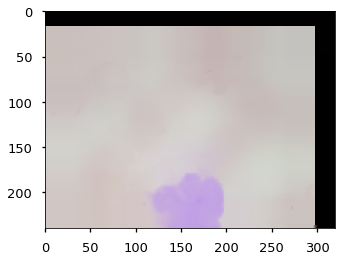

In [32]:
# Blurring of our example image, plot the result
blurred = blurr(imtest)
plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))

In [33]:
# Convert image to grayscale (easier to process, delete the third RGB dimension)
def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

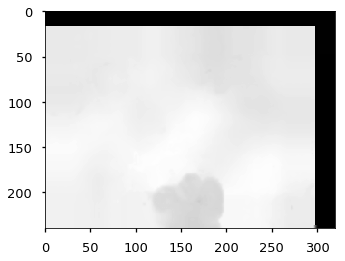

In [34]:
# Plot the result of grayscale function on our blurred image
imgray = to_grayscale(blurred)
plt.imshow(imgray, "gray")

In [35]:
# Neutralize black pixels from frame issues by changing their color to the average image color
def neutralize_frame(image, thresh=80):
    nonblack_avg = np.mean(image[image > thresh])
    image[image < thresh] = nonblack_avg

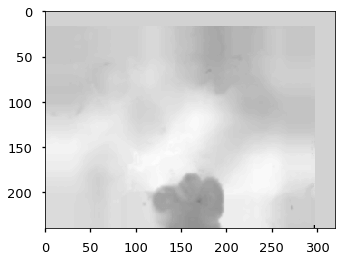

In [36]:
# Test neutralize frame function and plot the result
neutralize_frame(imgray)
plt.imshow(imgray, "gray")

In [37]:
# Threshold the resulting image to spot the darker zones more easily
# The thresholding level depends on the image : we take it to be the pth% percentile on pixel blackness
def thresholding(image, pth=2):
    percentile = int(np.percentile(image, pth))
    ret, thr = cv2.threshold(image, percentile, 255, cv2.THRESH_BINARY)
    return thr

In [38]:
# Take the negative of the image
def invert(image) :
    inverted = -(image - 255)
    return inverted

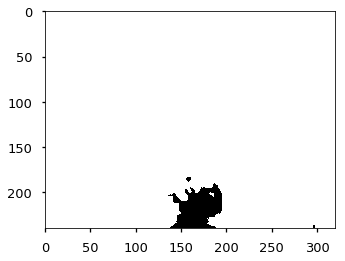

In [39]:
# Test of thresholding function and plot the result
thresholded = thresholding(imgray)
plt.imshow(thresholded, "gray")

In [40]:
# Filter out remaining noise (some isolated black pixels remain)
def noise_filtering(image, kernel_size=5):
    neg = invert(image)
    kernel = np.ones((kernel_size, kernel_size),np.uint8)
    closing = cv2.morphologyEx(neg, cv2.MORPH_OPEN, kernel)
    return invert(closing)

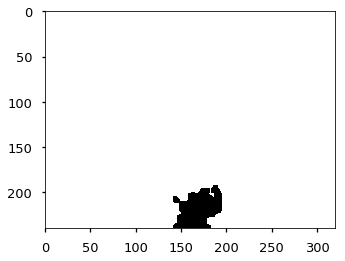

In [41]:
# Test of noise_filtering function and plot the result
closing = noise_filtering(thresholded)
plt.imshow(closing, "gray")

In [42]:
# We take the average index from the non white-pixels from thresholded image 
# to estimate the center of the cell we are trying to identify
def find_centre(threshim):
    centre = np.mean(np.argwhere(threshim != 255), axis=0).astype(int)
    return centre

In [43]:
# Test find center function
centre = find_centre(closing)
print(centre)

[217 169]


In [44]:
# Crop the image with npixs in each dimension around the center
def focus_on_centre(image, centre, npixs=150):
    limx = image.shape[0]
    limy = image.shape[1]
    if centre[0] - npixs//2 < 0:
        ax0 = 0
        ax1 = npixs
    elif centre[0] + npixs//2 > limx:
        ax0 = limx - npixs
        ax1 = limx
    else :
        ax0 = centre[0] - npixs//2
        ax1 = centre[0] + npixs//2
    if centre[1] - npixs//2 < 0:
        ay0 = 0
        ay1 = npixs
    elif centre[1] + npixs//2 > limy:
        ay0 = limy - npixs
        ay1 = limy
    else :
        ay0 = centre[1] - npixs//2
        ay1 = centre[1] + npixs//2
    if len(image.shape) == 3:
        return image[ax0 : ax1, ay0 : ay1, :]
    else :
        return image[ax0 : ax1, ay0 : ay1]

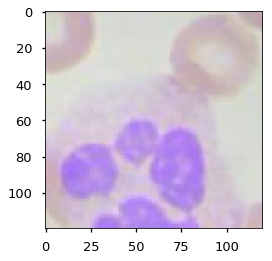

In [45]:
# Test focus on center function and plot the result
npixs = 120
imreduced = focus_on_centre(imtest, centre, npixs)
plt.imshow(cv2.cvtColor(imreduced, cv2.COLOR_BGR2RGB))

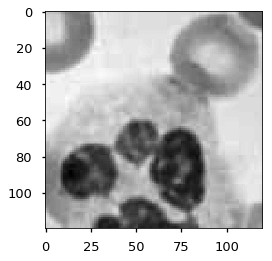

In [46]:
# We use grayscale version to simplify the problem and to be able to vectorize images
reduced_gray = to_grayscale(imreduced)
neutralize_frame(reduced_gray)
plt.imshow(reduced_gray, "gray")

In [47]:
# Better to have pixels of interest white (1.0) than black (0.0) for classification afterwards
def to_normalized_negative(image):
    inverted = invert(image).astype(float)
    normalized = (1.0 / 255.0) * inverted
    return normalized

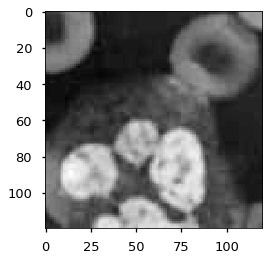

In [48]:
# Test to_normalized_negative and plot the result
negative = to_normalized_negative(reduced_gray)
plt.imshow(negative, "gray")

In [712]:
# Apply all the phases shown in the example
def centre_image(image, frame_thresh, pth, npixs):
    blurred = blurr(image)
    imgray = to_grayscale(blurred)
    neutralize_frame(imgray, frame_thresh)
    thresholded = thresholding(imgray, pth)
    closing = noise_filtering(thresholded)
    centre = find_centre(closing)
    imreduced = to_grayscale(focus_on_centre(image, centre, npixs))
    neutralize_frame(imreduced, frame_thresh)
    negative = to_normalized_negative(imreduced)
    return negative

In [713]:
def to_1d(image):
    return image.flatten()

In [714]:
def to_2d(vecimage):
    s = int(np.sqrt(vecimage.shape[0]))
    return vecimage.reshape(s, s)

In [753]:
start = time.clock()
neg = centre_image(imtest, 80, 2, 120)
end = time.clock()
print(end - start)

0.313802


In [754]:
# Paths to train images for the two classes
path_neutrophil = path + "/images/TEST/NEUTROPHIL/"
path_lymphocyte = path + "/images/TEST/LYMPHOCYTE/"

In [755]:
# Process all the images in the directory as shown before and return them stacked in a numpy array
def process_all_directory(dirpath, frame_thresh=80, pth=2, npixs=120):
    files = os.listdir(dirpath)
    nfiles = len(files)
    stacked = np.zeros((npixs ** 2, nfiles))
    i = 0
    for f in files:
        image = load_image(dirpath + f)
        stacked[:, i] = to_1d(centre_image(image, frame_thresh, pth, npixs))
        i += 1
    return stacked

In [756]:
# Process all train neutrophils images
start = time.clock()
neutrophils = process_all_directory(path_neutrophil)
end = time.clock()
print(end - start)

178.365942


In [757]:
# Save the result to an archive .gz file
start = time.clock()
np.savetxt(path + "neutrophils_test.gz", neutrophils)
end = time.clock()
print(end - start)

21.072334


In [758]:
# Process all train lymphocytes images
start = time.clock()
lymphocytes = process_all_directory(path_lymphocyte)
end = time.clock()
print(end - start)

183.175741


In [759]:
# Save the result to an archive .gz file
start = time.clock()
np.savetxt(path + "lymphocytes_test.gz", lymphocytes)
end = time.clock()
print(end - start)

19.561039


In [761]:
output_path = os.getcwd() + "/Graphs/"

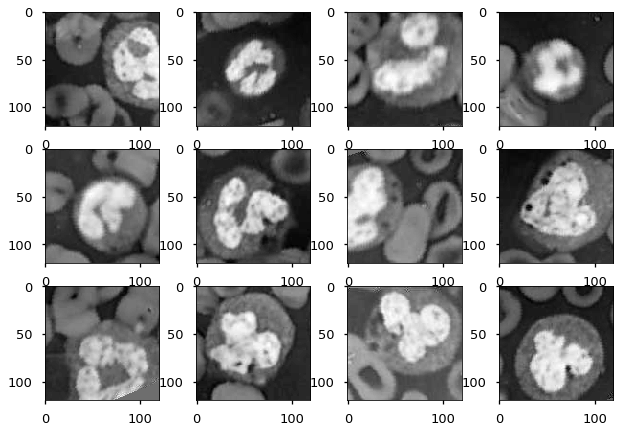

In [763]:
# Plot some examples of cropped neutrophils images
fig, axes = plt.subplots(3, 4)
for i in range(0, 4):
    for j in range(0, 3):
        axes[j, i].imshow(to_2d(neutrophils[:, i + 4*j]), "gray")
fig.savefig(output_path + "Neutrophils.svg")

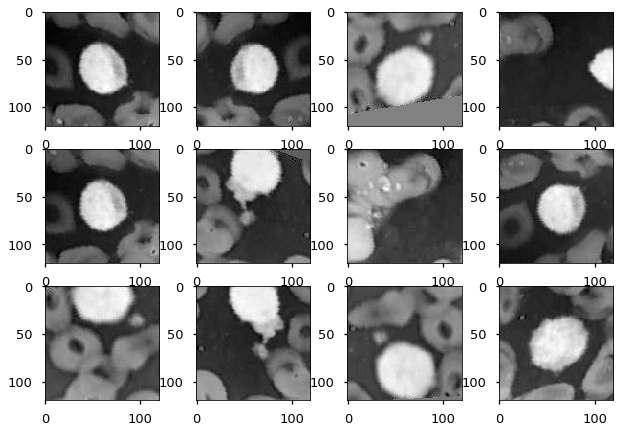

In [764]:
# Plot some examples of cropped lymphocytes images
fig, axes = plt.subplots(3, 4)
for i in range(0, 4):
    for j in range(0, 3):
        axes[j, i].imshow(to_2d(lymphocytes[:, i + 4*j]), "gray")
fig.savefig(output_path + "Lymphocytes.svg")